# Initial Data Reading and Cleaning

In [192]:
import pandas as pd
import numpy as np

df = pd.read_csv('./ingredients_refined.csv')

df = df.drop_duplicates(subset=['ingredient'])

ingredients = np.array(df['ingredient'].values)
price = np.array(df['price'].values)
metric = np.array(df['metric'].values)

# Building the amount matrix

In [193]:
import json

with open('./train.json', 'r') as f:
    recipes = json.load(f)

matrix = pd.DataFrame(columns=ingredients, index = [recipe['id'] for recipe in recipes])
matrix.columns = matrix.columns.str.strip()

for recipe in recipes:
    for ingredient in recipe["ingredients"]:
        for column in matrix.columns:
            if ingredient in column:  # Check if ingredient is a substring of the column
                matrix.loc[recipe["id"], column] = 1

matrix = matrix.fillna(0)
matrix.to_csv('./matrix.csv')

/var/folders/l7/ywb8q5r53j33j1lqzbzjyshm0000gn/T/ipykernel_35442/2305965186.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0)


# Modeling

### Set definitions

In [201]:
import gamspy as gp
import numpy as np
import gamspy.math as gpm

cont = gp.Container()
I = cont.addSet('I', records = [ingredients[idx] for idx in range(len(ingredients))], description = 'A set containing all of the valid ingredients')
R = cont.addSet('R', records = [recipe['id'] for recipe in recipes], description= 'A set containing all of the recipes that can be made')

### Parameter Definitions

In [202]:
C = cont.addParameter('C', domain=[I], description="Cost per unit of each of the ingredients", records = price)
A = cont.addParameter('A', domain=[R, I], description="Amount of ingredient i required in recipe r", records = np.array(matrix))
B = cont.addParameter('B', description="Budget to purchase ingredients", records=400)
lam = cont.addParameter('lam', description="Trade off parameter used to weight the regularizer", records = .01)

### Variable Definitions

In [203]:
z = cont.addVariable('z', "integer", domain=[I], description="Amount of ingredient i purchased")
x = cont.addVariable('x', "binary", domain=[R], description="Indicator variable to make recipe r")
l = cont.addVariable('l', "free", domain=[I], description="Leftover ingredients after all recipes are made")

### Equations

In [204]:
budget = cont.addEquation('budget', 'regular',
                        description="Constrains the total money spent on ingredients to be within the budget")
budget[:] = gp.Sum(I, C[I] * z[I]) <= B

ingredient_amounts = cont.addEquation('ingredient_amounts', 'regular', domain=[I],
                              description="Ensures enough ingredients are purchased to satisfy the selected recipes")
ingredient_amounts[I] = gp.Sum(R, A[R, I] * x[R]) <= z[I]

waste = cont.addEquation('waste', 'regular', domain=[I],
                          description="Sets the leftover variable equal to the amount of unused ingredients")
waste[I] = l[I] == z[I] -  gp.Sum(R, A[R, I] * x[R])

tot_recipes = cont.addEquation('tot_recipes', description="Ensures enough recipes for a weeks worth of dinner can be made")
tot_recipes[:] = gp.Sum(R, x[R]) >= 7

z.lo[:]= 0
l.lo[:] = 0

In [206]:
objective = gp.Sum(R, x[R]) - lam * gp.Sum(I, l[I])

recipe_optimization = cont.addModel(
    name='recipe_optimization',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MAX,
    objective=objective
)

In [207]:
recipe_optimization.solve(solver = 'cplex')
df = z.records
print(f"Amount of ingredients to purchase: {len(df[df['level'] > 0])}")
print(f"Recipes to make {x.records[x.records['level'] > 0]}")

Amount of ingredients to purchase: 42
Recipes to make         R  level  marginal  lower  upper  scale
1   25693    1.0       1.0    0.0    1.0    1.0
2   20130    1.0       1.0    0.0    1.0    1.0
6   45887    1.0       1.0    0.0    1.0    1.0
7    2698    1.0       1.0    0.0    1.0    1.0
9   31908    1.0       1.0    0.0    1.0    1.0
10  13121    1.0       1.0    0.0    1.0    1.0
11  49136    1.0       1.0    0.0    1.0    1.0
12  27976    1.0       1.0    0.0    1.0    1.0


# Sensitivity Analysis

## lambda sensitivity

## budget sensitivity

In [216]:
B.setRecords(300)

recipe_optimization.solve(solver = 'cplex')

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,7,217,228,MIP,CPLEX,0.021


/Users/liamsoule/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liamsoule/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

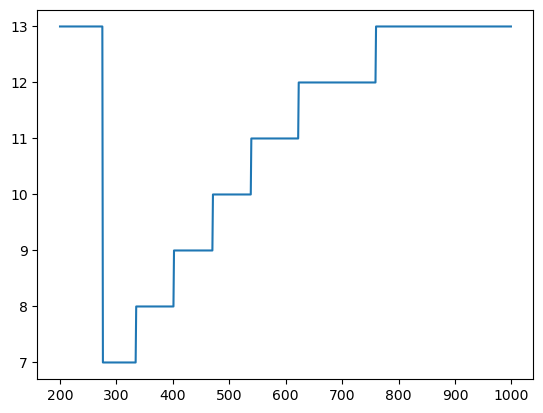

In [212]:
amount_recipes = []
budget = []
loss = []

for num in range(300, 1000):
    B.setRecords(num)
    recipe_optimization.solve(solver = 'cplex')
    df = x.records
    number_recipes = len(df[df['level'] > 0])
    loss.append(l.records['level'].sum())
    budget.append(num)
    amount_recipes.append(number_recipes)
    num += 50

import seaborn as sns

sns.lineplot(x = budget, y = amount_recipes)

In [ ]:
sns.lineplot(x = budget, y = loss)